In [1]:
import pyspark,ogr,json

### 下面这个一大个方法，主要用matplotlib绘制几何要素，做可视化用的

In [2]:
import matplotlib.pyplot as plt
def show(polyArr,poly2=None,polyArr2=None, 
         xm=(11135007,11138992),ym=(2709657, 2713334)):  
    fig = plt.figure(figsize=(12,9)) 
    ax = fig.gca() 
    ax.grid(alpha= 1)
    for i in range(len(polyArr)):
        px = json.loads(polyArr[i].ExportToJson())
        mpoly = plt.Polygon(px["coordinates"][0],
                            ec = '#000000',fc='gray', alpha = 0.5)
        ax.add_patch(mpoly)
        if len(px["coordinates"]) > 1:
            mpoly = plt.Polygon(px["coordinates"][1],
                                ec = '#000000',fc='white', alpha = 1)
            ax.add_patch(mpoly)
    
    if poly2:
        px = json.loads(poly2.ExportToJson())
        mpoly = plt.Polygon(px["coordinates"][0],
                                ec = '#000000',fc='blue', alpha = 0.2)
        ax.add_patch(mpoly)
    
    if polyArr2:
        for i in range(len(polyArr2)):
            gjson = json.loads(polyArr2[i].ExportToJson())
            if gjson["type"] == "MultiPolygon":
                for p in range(len(gjson["coordinates"])):
                    mpoly = plt.Polygon(gjson["coordinates"][p][0],
                                       ec = '#000000',fc='red', alpha = 0.5,hatch='/')
                    ax.add_patch(mpoly)
            else:
                mpoly = plt.Polygon(gjson["coordinates"][0],
                                       ec = '#000000',fc='red', alpha = 0.5,hatch='/')
                ax.add_patch(mpoly)

    ax.set_autoscale_on= False
    ax.set_xlim(xm[0],xm[1])
    ax.set_ylim(ym[0],ym[1])

### 查看一下示例数据情况

In [3]:
poly = [ogr.CreateGeometryFromWkt(row.split("\t")[1]) \
        for row in open("./data/dltb.tsv",encoding="utf-8")][1:]

### 构建一个用来选择的要素，这里直接构建了一条线，然后进行缓冲。

In [20]:
line = 'LINESTRING(11136593  2713221,11137104 2712110, \
11135386 2710566,11138686 2711500)'
buf = ogr.CreateGeometryFromWkt(line).Buffer(100)

### 用于计算的和选择的数据如下

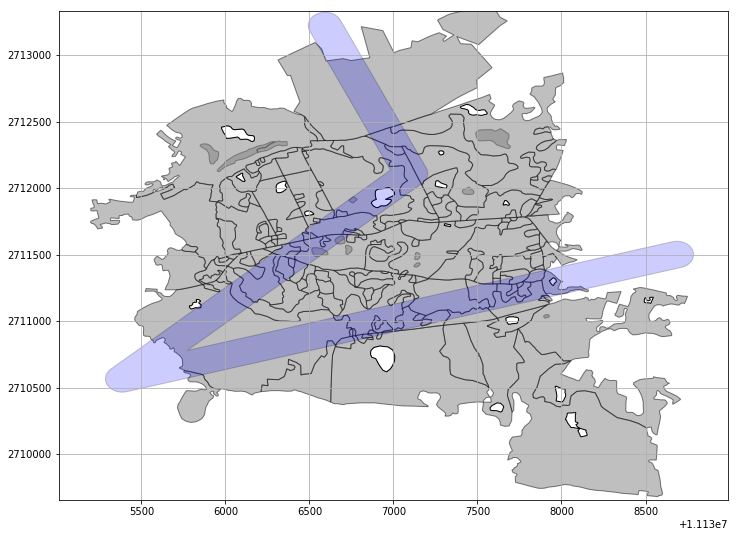

In [21]:
show(poly,buf)

In [23]:
sc = pyspark.SparkContext()

# 标准流程：清洗过滤、计算、提交、可视化

### 1、过滤掉头，且进行清洗

In [24]:
def filterHeader(line):
    geoline = line.split("\t")
    try:
        return ogr.CreateGeometryFromWkt(geoline[1]).IsValid()
    except:
        return False

In [25]:
rdd = sc.textFile("./data/dltb.tsv")\
.filter(lambda line : filterHeader(line))

### 2、进行空间选择，如果相交的，就选择出来

In [26]:
def SelectByLocation(line,selectGeom):
    return selectGeom.Intersects(ogr.CreateGeometryFromWkt(line.split("\t")[1]))

In [27]:
res = rdd.filter(lambda line : SelectByLocation(line,buf)).collect()

### 3、可视化

In [28]:
p2 = []
for pl in res:
    p2.append(ogr.CreateGeometryFromWkt(pl.split("\t")[1]))

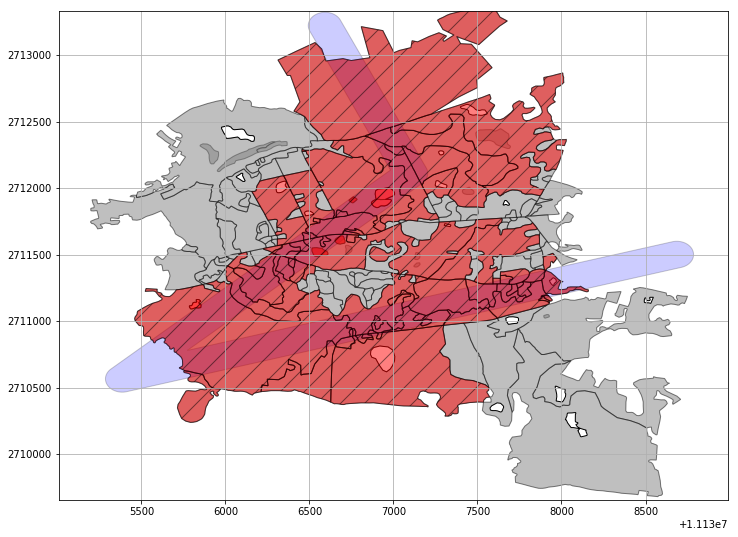

In [31]:
show(poly,buf,p2)

## 统计选择的结果

In [32]:
rdd.filter(lambda line : SelectByLocation(line,buf))\
.map(lambda line:(line.split("\t")[3],
                float(line.split("\t")[4])))\
.reduceByKey(lambda x,y:x+y).collect()

[('旱地', 59473.91),
 ('园地', 537526.99),
 ('农村居民点用地', 43601.96),
 ('其他独立建设用地', 1253676.62),
 ('林地', 670693.0599999999)]

# 进行精确裁切的统计

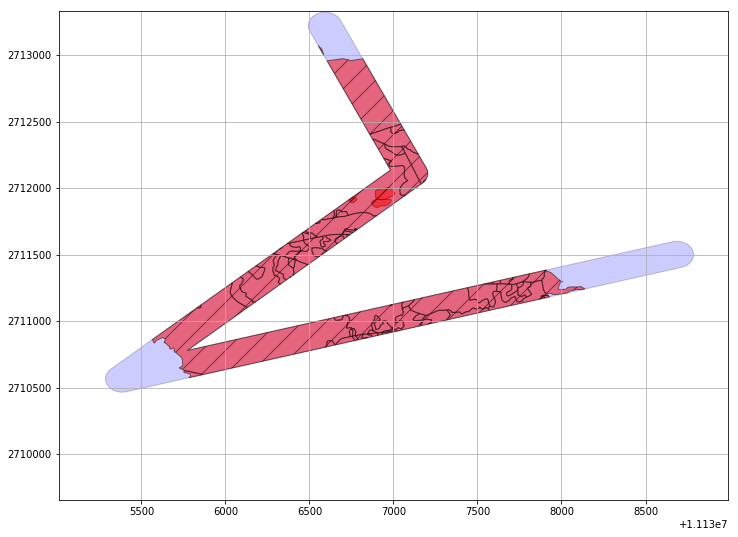

In [43]:
res = rdd.filter(lambda line : SelectByLocation(line,buf))\
.map(lambda line: \
     (buf.Intersection(\
            ogr.CreateGeometryFromWkt(line.split("\t")[1]))))\
.collect()
show([],buf,res)

## 统计的时候，因为裁切掉了一部分，所以先用切割的几何面积除以原来的几何面积，算出被切割掉的比例。
## 然后用图斑面积乘以这个比例，得到被切割掉的面积

## 不直接用几何面积，是因为业务统计的时候，会优先使用tbmj这个台账记录的数据，而非实测几何面积数据

In [37]:
def mapClip(line,buf):
    geo = ogr.CreateGeometryFromWkt(line.split("\t")[1])
    intgeo = buf.Intersection(geo)
    dlmc = line.split("\t")[3]
    tbmj = float(line.split("\t")[4])
    geoArea = geo.GetArea()
    intGeoArea = intgeo.GetArea()
    res = tbmj *(intGeoArea/geoArea)
    return (dlmc, res)

In [38]:
res = rdd.filter(lambda line : SelectByLocation(line,buf))\
.map(lambda line: mapClip(line,buf))\
.reduceByKey(lambda x,y:x+y).collect()

In [39]:
res

[('旱地', 34763.21236045014),
 ('园地', 202893.84296418808),
 ('农村居民点用地', 43601.96),
 ('其他独立建设用地', 311708.56069191673),
 ('林地', 370055.24933349004)]